## Big Mart Sales  - Prediction

### The Problem Statement
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def getcsv_data(testfile, trainfile):
    #Read CSV data files:
    train = pd.read_csv(trainfile)
    test = pd.read_csv(testfile)
    
    # Including new column named source and giving the value as 'train' / 'test' 
    # to identify from where exactly the data was taken
    train['source']='train'
    test['source']='test'
    
    # Combining the 2 dataframes into a single dataframe
    dataset = pd.concat([train, test],ignore_index=True, sort=False)
    print ('Train dataframe :-', train.shape)
    print ('Test dataframe :-', test.shape)
    print ('Combined dataset dataframe :-', dataset.shape)
    return dataset

In [3]:
dataset= getcsv_data('data/BigMartTest.csv','data/BigMartTrain.csv' )

Train dataframe :- (8523, 13)
Test dataframe :- (5681, 12)
Combined dataset dataframe :- (14204, 13)


In [4]:
dataset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [5]:
dataset.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [6]:
# Alternatively use th following function
dataset.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [7]:
dataset.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
dataset.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

In [9]:
#Filter categorical variables
categorical_columns = [x for x in dataset.dtypes.index if dataset.dtypes[x]=='object']
categorical_columns

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'source']

In [10]:
# Alternatively use th following function
cat_cols = []
for i in dataset.dtypes.index :
    if dataset.dtypes[i]=='object' :
        cat_cols.append(i)
cat_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'source']

In [11]:
#Exclude Identifier columns and source column which was created newly:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
categorical_columns

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [12]:
#Print frequency of categories
for col in categorical_columns:
    print ('Frequency of Categories for varible : ', col)
    print (dataset[col].value_counts())
    print('---------------------------------------------------')

Frequency of Categories for varible :  Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
---------------------------------------------------
Frequency of Categories for varible :  Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64
---------------------------------------------------
Frequency of Categories for varible :  Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64
------------------------------------

The output gives us following observations:

> Item_Fat_Content: Some of ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’. Also, some of ‘Regular’ are mentioned as ‘regular’. <br>
Item_Type: Not all categories have substantial numbers. It looks like combining them can give better results. <br>
Outlet_Type: Supermarket Type2 and Type3 can be combined. But we should check if that’s a good idea before doing it.

### 3. Data Cleaning
> Imputing missing values and Treating outliers

#### a. Item_Weight with the help of Item_Identifier

In [17]:
dataset.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

Out of the independet values, we can see that Item_Weight and Outlet_Size columns have missing values

In [18]:
#Determine the average weight per item:
Item_ave_weight = dataset.pivot_table(values='Item_Weight', index='Item_Identifier')
Item_ave_weight.head()

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [19]:
#Get a boolean variable specifying missing Item_Weight values
miss_IW_rows = dataset['Item_Weight'].isnull() # Output is a list of boolean values
miss_IW_rows.head()

0    False
1    False
2    False
3    False
4    False
Name: Item_Weight, dtype: bool

In [20]:
dataset.loc[miss_IW_rows,'Item_Weight'] = dataset.loc[miss_IW_rows,'Item_Identifier'].apply(lambda x: Item_ave_weight.loc[x])    

In [21]:
print ('Orignal #missing values:', sum(miss_IW_rows))
print ('Final #missing values:', sum(dataset['Item_Weight'].isnull()))

Orignal #missing values: 2439
Final #missing values: 0


#### b. Outlet_Size with the help of Outlet_Type

In [22]:
#### a. Item_Weight with the help of Item_Identifier#Import mode function:
from statistics import mode
#Determining the mode for each
Item_Outlet_size = dataset.pivot_table(values='Outlet_Size', index='Outlet_Type',aggfunc=(lambda x:mode(x)))
Item_Outlet_size

,Outlet_Size
Outlet_Type,
Supermarket Type1,Small
Supermarket Type2,Medium
Supermarket Type3,Medium


In [23]:
dataset.Outlet_Type.unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

As the mode parameter is not indicating the 'Grocery Store' value, <br> we will need to 'physically' impute the Outlet_Size as 'Small' to Outlet_Type 'Grocery Store'.

In [24]:
miss_OS_GS_rows = dataset [(dataset['Outlet_Type'] == 'Grocery Store') & (dataset['Outlet_Size'].isnull())].index

In [25]:
dataset.loc[miss_OS_GS_rows,'Outlet_Size'] = 'Small'

In [26]:
miss_OS_rows = dataset['Outlet_Size'].isnull()

In [27]:
dataset.loc[miss_OS_rows,'Outlet_Size'] = dataset.loc[miss_OS_rows,'Outlet_Type'].apply(lambda x: Item_Outlet_size.loc[x])

In [28]:
print ('Original missing : ', sum(miss_OS_rows))
print ('After update missing : ' , sum(dataset['Outlet_Size'].isnull()))

Original missing :  3091
After update missing :  0


### 4.0 Feature Engineering

Considering to __combine values__ in column __Outlet_Type__

In [29]:
dataset.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088,train
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528,train
7,FDP10,19.000,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,train
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Small,Tier 2,Supermarket Type1,1076.5986,train
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,Small,Tier 2,Supermarket Type1,4710.5350,train


In [30]:
 dataset.groupby(['Outlet_Type'])['Item_Outlet_Sales'].sum()

Outlet_Type
Grocery Store        3.680343e+05
Supermarket Type1    1.291734e+07
Supermarket Type2    1.851823e+06
Supermarket Type3    3.453926e+06
Name: Item_Outlet_Sales, dtype: float64

In [31]:
dataset.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


The mean outlet sales values *vary significantly* and hence we will leave them as it is.

####  Item_Visibility with the help of Item_Identifier

In [32]:
dataset[dataset['Item_Visibility'] == 0].head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
3,FDX07,19.200,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.930,Low Fat,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train
5,FDP36,10.395,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088,train
10,FDY07,11.800,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266,train
32,FDP33,18.700,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064,train


In [33]:
Item_ave_visi = dataset.pivot_table(values='Item_Visibility', index='Item_Identifier')

In [34]:
Item_ave_visi.head()

,Item_Visibility
Item_Identifier,
DRA12,0.034938
DRA24,0.045646
DRA59,0.133384
DRB01,0.079736
DRB13,0.006799


In [35]:
miss_val_ItemVis = (dataset['Item_Visibility'] == 0)

In [36]:
dataset.loc[miss_val_ItemVis,'Item_Visibility'] = dataset.loc[miss_val_ItemVis,'Item_Identifier'].apply(lambda x: Item_ave_visi.loc[x])

In [37]:
print ('Number of 0 values in Item_Visibility initially:' , sum (miss_val_ItemVis))
print ('Number of 0 values in Item_Visibility after impute:' , sum (dataset['Item_Visibility'] == 0))

Number of 0 values in Item_Visibility initially: 879
Number of 0 values in Item_Visibility after impute: 0


In [38]:
#Determine another variable with means ratio
dataset['Item_Visibility_MeanRatio'] = dataset.apply(lambda x: x['Item_Visibility']/Item_ave_visi.loc[x,'Item_Visibility'], axis=1)

c:\users\nags\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


ValueError: ('cannot index with vector containing NA / NaN values', 'occurred at index 8523')

#### Create a broad category of Type of Item

In [39]:
# Get the first two characters of ID:
dataset['Item_Type_Combined'] = dataset['Item_Identifier'].apply(lambda x: x[0:2])

In [59]:
dataset['Item_Type_Combined'].unique()

array([1, 0, 2], dtype=int64)

In [40]:
# Rename them to more intuitive categories:
dataset['Item_Type_Combined'] = dataset['Item_Type_Combined'].map(
    {'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})

In [41]:
dataset['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

#### Determine the years of operation of a store

In [42]:
#Years in operation :
import datetime
now = datetime.datetime.now()
dataset['Outlet_Since_Years'] = now.year - dataset['Outlet_Establishment_Year']

#### Modify categories of Item_Fat_Content

In [43]:
#Change categories of low fat:
print ('Original Item_Fat_Content Categories:' ) 
print (dataset['Item_Fat_Content'].value_counts())

Original Item_Fat_Content Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64


In [44]:
# Rename Item_Fat_Content to proper names (consider upper case also)
dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print ('Item_Fat_Content Categories after renaming values :' ) 
print (dataset['Item_Fat_Content'].value_counts())

Item_Fat_Content Categories after renaming values :
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [45]:
#Marking non-consumables as separate category in Item_Fat_Content:
dataset.loc[dataset['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
dataset['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

#### Encoding of categorical variables to numericals

In [46]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [47]:
dataset.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'source', 'Item_Type_Combined',
       'Outlet_Since_Years'],
      dtype='object')

In [48]:
dataset.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
Item_Type_Combined            object
Outlet_Since_Years             int64
dtype: object

In [49]:
#New variable for outlet
dataset['Outlet'] = le.fit_transform(dataset['Outlet_Identifier'])

In [53]:
dataset[['Outlet_Identifier', 'Outlet']].head()

,Outlet_Identifier,Outlet
0,OUT049,9
1,OUT018,3
2,OUT049,9
3,OUT010,0
4,OUT013,1


In [54]:
cat_cols1 = []
for i in dataset.dtypes.index :
    if dataset.dtypes[i]=='object' :
        cat_cols1.append(i)
cat_cols1

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'source',
 'Item_Type_Combined']

In [55]:
# Adding varaibles Outlet to the list and excluding identifiers and Item_Type
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']

In [56]:
# Encoding categorical variables to numerics based on the above list (var_mod) created
le_x = LabelEncoder()
for i in var_mod:
    dataset[i] = le_x.fit_transform(dataset[i])

In [57]:
dataset[['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']].head()

,Item_Fat_Content,Outlet_Location_Type,Outlet_Size,Item_Type_Combined,Outlet_Type,Outlet
0,0,0,1,1,1,9
1,2,2,1,0,2,3
2,0,0,1,1,1,9
3,2,2,2,1,0,0
4,1,2,0,2,1,1


#### One Hot encoding of variables

> One-Hot-Coding refers to creating dummy variables, one for each category of a categorical variable. 

>For example, the Item_Fat_Content has 3 categories – ‘Low Fat’, ‘Regular’ and ‘Non-Edible’. <br> 
One hot coding __will remove__ this variable __and generate__ 3 __new variables__. Each will have binary numbers – 0 (if the category is not present) and 1(if category is present). 

>This can be done using ‘get_dummies’ function of Pandas.

In [60]:
dataset = pd.get_dummies(dataset, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [61]:
dataset.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Outlet_Since_Years             int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
O

In [62]:
dataset[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


#### Exporting the data

In [65]:
dataset[['Item_Type','Item_Type_Combined_0', 'Outlet_Establishment_Year', 'Outlet_Since_Years']].head()
# Item type --> A new column 'Item_Type_Combined' was created mainly to obtain more counts in this categorical 
# varlaible, and was given intutive names based on the codes. The Item_Type column is 'repetition' of Item_Type_Combined.

# Outlet_Establishment_Year --> A new column 'Outlet_Since_Years' was created using 'Outlet_Establishment_Year' column 

,Item_Type,Item_Type_Combined_0,Outlet_Establishment_Year,Outlet_Since_Years
0,Dairy,0,1999,19
1,Soft Drinks,1,2009,9
2,Meat,0,1999,19
3,Fruits and Vegetables,0,1998,20
4,Household,0,1987,31


In [66]:
# Drop the columns which have been converted to different types:
dataset.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

In [67]:
# Splitting the dataset 'back' into test and train datasets:
train = dataset.loc[dataset['source']=="train"]
test = dataset.loc[dataset['source']=="test"]

In [68]:
# Dropping unnecessary columns:
test = test.drop(['Item_Outlet_Sales','source'],axis=1) # dropping dependent variable 'Item_Outlet_Sales' from this dataset
train = train.drop(['source'],axis=1)

In [69]:
test.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Outlet_Since_Years', 'Item_Fat_Content_0',
       'Item_Fat_Content_1', 'Item_Fat_Content_2', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0',
       'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1',
       'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7',
       'Outlet_8', 'Outlet_9'],
      dtype='object')

In [70]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Since_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Fat_Content_2',
       'Outlet_Location_Type_0', 'Outlet_Location_Type_1',
       'Outlet_Location_Type_2', 'Outlet_Size_0', 'Outlet_Size_1',
       'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1', 'Outlet_Type_2',
       'Outlet_Type_3', 'Item_Type_Combined_0', 'Item_Type_Combined_1',
       'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3',
       'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

In [71]:
# Exporting csv files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

### 4. Building the model

In [72]:
# Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()
mean_sales

2181.288913575032

In [73]:
# Defining a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]

In [74]:
# Implying the mean sales value to the Item_Outlet_Sales column
base1.loc[:,'Item_Outlet_Sales'] = mean_sales

c:\users\nags\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\nags\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [75]:
# Exporting the submission file
base1.to_csv("alg0.csv",index=False)

__Function to automate submission to Hackothon__:
> A generic function which takes the algorithm and data as input and makes the model, performs cross-validation and generates submission

In [76]:
#Define target and ID columns:

target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

from sklearn.model_selection import cross_val_score
from sklearn import metrics
def modelfit(algorthm, dftrain, dftest, predictors, target, IDcol, filename):

    #Fit the algorthmorithm on the data
    # Creating ID columns and target columns in the new vriable
    algorthm.fit(dftrain[predictors], dftrain[target]) # similar to the base dataframe created above with the predictor & target columns
        
    #Predict training set:
    dftrain_predictions = algorthm.predict(dftrain[predictors]) # creating new predictor column 

    #Perform cross-validation:
    cv_score = cross_val_score(algorthm, dftrain[predictors], dftrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\n------Model Report----\n")
    print ("RMSE : " , np.sqrt(metrics.mean_squared_error(dftrain[target].values, dftrain_predictions)))
    print ("CV Score Mean : %.4g" %(np.mean(cv_score)))
    print ("CV Score Std : %.4g" %(np.std(cv_score)))
    print ("CV Score Min : %.4g" %(np.min(cv_score)))
    print ("CV Score Max : %.4g" %(np.max(cv_score)))
    
    #Predict on testing data:
    dftest[target] = algorthm.predict(dftest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dftest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

### Linear Regression Model

In [77]:
train.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Item_Outlet_Sales,Outlet_Since_Years,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,9.30,0.016047,249.8092,OUT049,3735.1380,19,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.92,0.019278,48.2692,OUT018,443.4228,9,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.50,0.016760,141.6180,OUT049,2097.2700,19,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.20,0.017834,182.0950,OUT010,732.3800,20,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.009780,53.8614,OUT013,994.7052,31,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [78]:
# Building a list of independent varaibles to build the model
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

# Excluding Identifiers (used for submission) and dependent variable column
predictors = [x for x in train.columns if x not in [target]+IDcol]
predictors

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Since_Years',
 'Item_Fat_Content_0',
 'Item_Fat_Content_1',
 'Item_Fat_Content_2',
 'Outlet_Location_Type_0',
 'Outlet_Location_Type_1',
 'Outlet_Location_Type_2',
 'Outlet_Size_0',
 'Outlet_Size_1',
 'Outlet_Size_2',
 'Outlet_Type_0',
 'Outlet_Type_1',
 'Outlet_Type_2',
 'Outlet_Type_3',
 'Item_Type_Combined_0',
 'Item_Type_Combined_1',
 'Item_Type_Combined_2',
 'Outlet_0',
 'Outlet_1',
 'Outlet_2',
 'Outlet_3',
 'Outlet_4',
 'Outlet_5',
 'Outlet_6',
 'Outlet_7',
 'Outlet_8',
 'Outlet_9']

In [79]:
# Building a linear regression model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
alg1 = LinearRegression(normalize=True)

In [80]:
# Using the FUNCTION which takes the algorithm and data as input and makes the model 
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')


------Model Report----

RMSE :  1127.439654756725
CV Score Mean : 1129
CV Score Std : 43.18
CV Score Min : 1075
CV Score Max : 1210


In [81]:
coef1 = pd.Series(alg1.coef_, predictors).sort_values(ascending=True)
coef1

Outlet_Size_0            -1.065072e+16
Outlet_Size_1            -9.632974e+15
Outlet_Size_2            -5.120711e+15
Outlet_Type_0            -2.635758e+15
Outlet_Location_Type_1   -1.919235e+15
Outlet_Location_Type_0   -1.859857e+15
Item_Fat_Content_0       -1.791653e+15
Item_Fat_Content_2       -1.791653e+15
Outlet_0                 -1.471849e+15
Outlet_8                 -1.256450e+15
Outlet_7                 -9.670049e+14
Item_Type_Combined_2     -9.354932e+14
Outlet_6                 -8.749778e+14
Outlet_2                 -7.369373e+14
Item_Fat_Content_1       -6.937136e+14
Outlet_3                 -4.836116e+14
Outlet_Type_1            -2.181988e+14
Outlet_Type_3            -1.671652e+14
Outlet_5                 -2.635454e+13
Item_Visibility          -2.200600e+02
Item_Weight               4.331065e-02
Item_MRP                  1.555566e+01
Outlet_Since_Years        4.601352e+13
Item_Type_Combined_0      1.624466e+14
Item_Type_Combined_1      1.624466e+14
Outlet_4                 

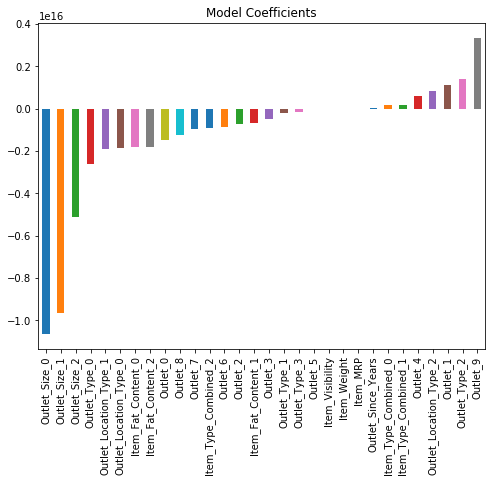

In [82]:
plt.figure(figsize=(8,6))
coef1.plot(kind='bar', title='Model Coefficients')
plt.show()

### Ridge Regression Model:

In [83]:
# Building a list of independent varaibles to build the model
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
predictors = [x for x in train.columns if x not in [target]+IDcol]

In [84]:
# Building a Ridge regression model 
alg2 = Ridge(alpha=0.05,normalize=True)


------Model Report----

RMSE :  1128.4910748126922
CV Score Mean : 1130
CV Score Std : 44.6
CV Score Min : 1076
CV Score Max : 1217


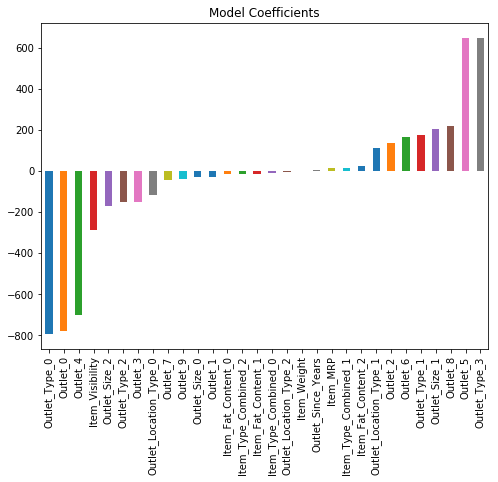

In [86]:
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values(ascending=True)
plt.figure(figsize=(8,6))
coef2.plot(kind='bar', title='Model Coefficients')
plt.show()

In [88]:
coef2

Outlet_Type_0            -794.564995
Outlet_0                 -777.519881
Outlet_4                 -702.106388
Item_Visibility          -287.449576
Outlet_Size_2            -171.012385
Outlet_Type_2            -152.433397
Outlet_3                 -152.433397
Outlet_Location_Type_0   -115.153996
Outlet_7                  -46.015215
Outlet_9                  -39.177373
Outlet_Size_0             -27.562750
Outlet_1                  -27.562750
Item_Fat_Content_0        -14.581686
Item_Type_Combined_2      -14.545545
Item_Fat_Content_1        -14.545545
Item_Type_Combined_0       -9.840159
Outlet_Location_Type_2     -6.076412
Item_Weight                 0.214083
Outlet_Since_Years          3.646256
Item_MRP                   14.812184
Item_Type_Combined_1       15.098906
Item_Fat_Content_2         25.574440
Outlet_Location_Type_1    112.159842
Outlet_2                  134.578282
Outlet_6                  165.722300
Outlet_Type_1             174.934368
Outlet_Size_1             203.164898
O

### Decision Tree Model

In [89]:
# Building a list of independent varaibles to build the model
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
predictors = [x for x in train.columns if x not in [target]+IDcol]

In [90]:
# Building a Decision Tree regression model 
from sklearn.tree import DecisionTreeRegressor
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)



------Model Report----

RMSE :  1059.8136992241036
CV Score Mean : 1091
CV Score Std : 44.23
CV Score Min : 1004
CV Score Max : 1174


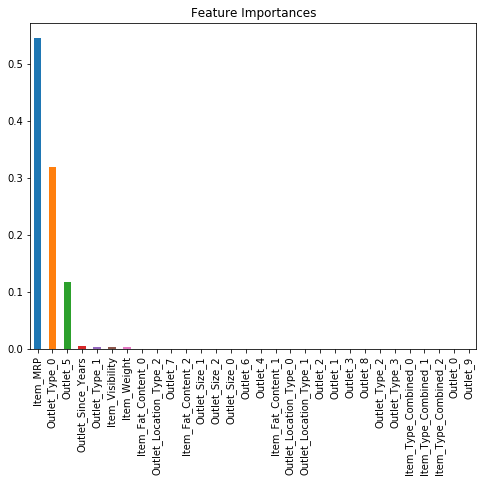

In [91]:
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
plt.figure(figsize=(8,6))
coef3.plot(kind='bar', title='Feature Importances')
plt.show()

In [93]:
coef3

Item_MRP                  0.545179
Outlet_Type_0             0.319194
Outlet_5                  0.118195
Outlet_Since_Years        0.005147
Outlet_Type_1             0.003913
Item_Visibility           0.003283
Item_Weight               0.002856
Item_Fat_Content_0        0.000832
Outlet_Location_Type_2    0.000530
Outlet_7                  0.000509
Item_Fat_Content_2        0.000158
Outlet_Size_1             0.000111
Outlet_Size_2             0.000091
Outlet_Size_0             0.000000
Outlet_6                  0.000000
Outlet_4                  0.000000
Item_Fat_Content_1        0.000000
Outlet_Location_Type_0    0.000000
Outlet_Location_Type_1    0.000000
Outlet_2                  0.000000
Outlet_1                  0.000000
Outlet_3                  0.000000
Outlet_8                  0.000000
Outlet_Type_2             0.000000
Outlet_Type_3             0.000000
Item_Type_Combined_0      0.000000
Item_Type_Combined_1      0.000000
Item_Type_Combined_2      0.000000
Outlet_0            

Here you can see that the RMSE is 1058 and the mean CV error is 1091. <br>
This tells us that the __model is slightly overfitting__. <br> 
> Lets try making a decision tree with just top 4 variables, a max_depth of 8 and min_samples_leaf as 150.

In [95]:
# Building a list of independent varaibles to build the model
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
# Making a decision tree with just **top 4** variables based on the above coeffecient values
predictors = ['Item_MRP','Outlet_Type_0', 'Outlet_5', 'Outlet_Since_Years']

In [96]:
# Building a Decision Tree regression model 
# Considering a max_depth of 8 and min_samples_leaf as 150.
from sklearn.tree import DecisionTreeRegressor
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)


------Model Report----

RMSE :  1071.2364214016316
CV Score Mean : 1096
CV Score Std : 43.3
CV Score Min : 1027
CV Score Max : 1172


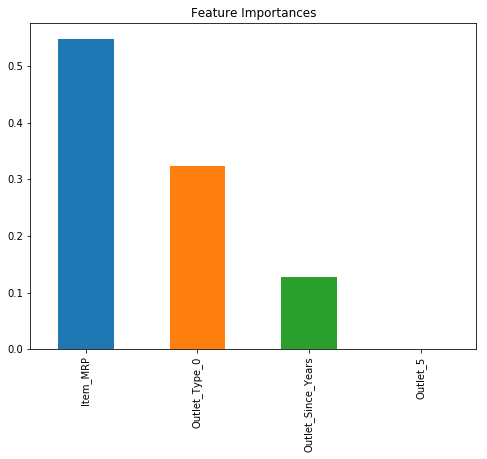

In [97]:
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
plt.figure(figsize=(8,6))
coef4.plot(kind='bar', title='Feature Importances')
plt.show()

Other parameters can be fine tuned to bring down the overfitting

### Random Forest Model

In [98]:
# Building a list of independent varaibles to build the model
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
predictors = [x for x in train.columns if x not in [target]+IDcol]

In [99]:
from sklearn.ensemble import RandomForestRegressor
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)


------Model Report----

RMSE :  1073.274773240269
CV Score Mean : 1083
CV Score Std : 43.88
CV Score Min : 1019
CV Score Max : 1160


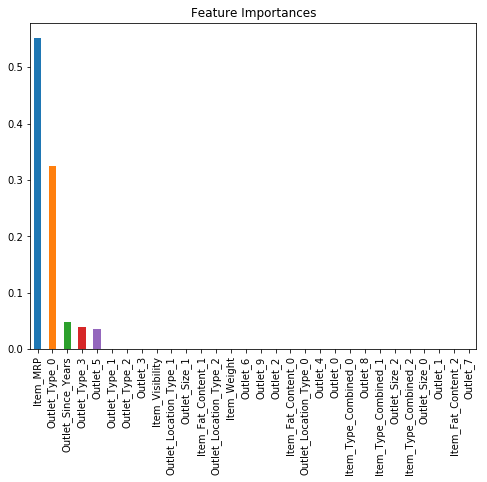

In [100]:
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
plt.figure(figsize=(8,6))
coef5.plot(kind='bar', title='Feature Importances')
plt.show()

You might feel this is a very small improvement but as our model gets better, achieving even minute improvements becomes exponentially difficult. <br>
>Lets try another random forest with max_depth of 6 and 400 trees. Increasing the number of trees makes the model robust but is computationally expensive.

In [101]:
# Building Random Forest model with max_depth of 6 and 400 trees
from sklearn.ensemble import RandomForestRegressor
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)


------Model Report----

RMSE :  1068.2681119103584
CV Score Mean : 1083
CV Score Std : 43.4
CV Score Min : 1021
CV Score Max : 1158


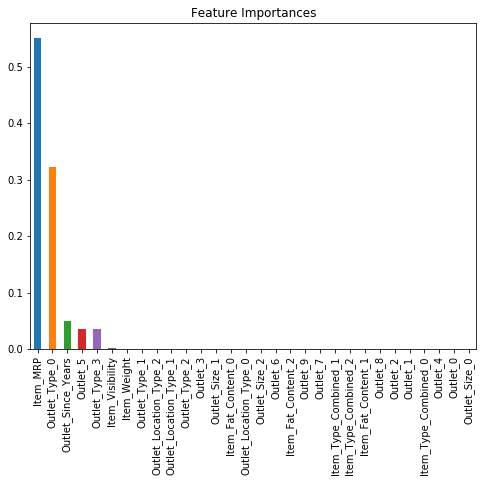

In [102]:
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
plt.figure(figsize=(8,6))
coef6.plot(kind='bar', title='Feature Importances')
plt.show()

__End Notes__<br>
This article took us through the entire journey of solving a data science problem. We started with making some hypothesis about the data without looking at it. Then we moved on to data exploration where we found out some nuances in the data which required remediation. Next, we performed data cleaning and feature engineering, where we imputed missing values and solved other irregularities, made new features and also made the data model-friendly by one-hot-coding. Finally we made regression, decision tree and random forest model and got a glimpse of how to tune them for better results.

I believe everyone reading this article should attain a good score in BigMart Sales now. For beginners, you should achieve at least a score of 1150 and for the ones already on the top, you can use some feature engineering tips from here to go further up. All the best to all!

Did you find this article useful? Could you make some more interesting hypothesis? What other features did you create? Were you able to get a better score with GBM & XGBoost? Feel free to discuss your experiences in comments below or on the discussion portal and we’ll be more than happy to discuss.